<a href="https://colab.research.google.com/github/Maks6666/ML/blob/main/%D0%94%D0%97_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [67]:
import pandas as pd

In [68]:
import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)

Дані про банани

In [69]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/banana_quality.csv')

df['Quality'] = df['Quality'].map({'Good': 1, 'Bad': 0})

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [70]:
df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,0.380309,0.626747,0.680712,0.360975,0.567312,0.671933,0.543416,1
1,0.349951,0.628093,0.485275,0.293682,0.481689,0.646850,0.545720,1
2,0.478460,0.699448,0.572694,0.283811,0.499358,0.716580,0.617337,1
3,0.446465,0.705394,0.595677,0.374028,0.473461,0.633590,0.556625,1
4,0.541672,0.687704,0.458841,0.378242,0.442847,0.579430,0.705908,1


In [71]:
from sklearn.model_selection import train_test_split

X = df.drop('Quality', axis="columns")
y = df["Quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Потрібно на основі інформації про банан спрогнозувати його якість `Quality`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [72]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X.values)
    self.y = torch.FloatTensor(y.values)
    self.y = self.y.reshape(-1, 1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [73]:
train_dataset[0]

(tensor([0.4368, 0.6901, 0.6155, 0.3530, 0.5191, 0.6285, 0.7567]),
 tensor([1.]))

In [74]:
train_dataset[0][0].device

device(type='cpu')

In [75]:
test_dataset[0][0].device

device(type='cpu')

In [76]:
len(train_dataset)

6400

# Завдання 2
Створіть DataLoader

In [77]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,
                        batch_size=256,
                        shuffle=True)



test_dataloader = DataLoader(test_dataset,
                        batch_size=256,
                        shuffle=True)

# Завдання 3
Створіть нейромережу

In [78]:
from torch import nn
import torch.nn.functional as F


class Model(nn.Module):
  def __init__(self, input_layer, hidden_layer, output_layer):
    super().__init__()

    self.linear_1 = nn.Linear(input_layer, hidden_layer)
    self.linear_2 = nn.Linear(hidden_layer, hidden_layer-6)
    self.linear_3 = nn.Linear(hidden_layer-6, hidden_layer-10)
    self.linear_4 = nn.Linear(hidden_layer-10, hidden_layer-14)
    self.linear_5 = nn.Linear(hidden_layer-14, output_layer)


  def forward(self, x):
    out = self.linear_1(x)
    out = F.relu(out)
    out = self.linear_2(out)
    out = F.relu(out)
    out = self.linear_3(out)
    out = F.relu(out)
    out = self.linear_4(out)
    out = F.relu(out)
    out = self.linear_5(out)
    out = F.sigmoid(out)
    return out


  def predict(self, X, device='cpu'):
      X = torch.FloatTensor(np.array(X)).to(device)

      with torch.no_grad():
        y_pred = self.forward(X)

      return y_pred.cpu().numpy()


model = Model(7, 20, 1)
model

Model(
  (linear_1): Linear(in_features=7, out_features=20, bias=True)
  (linear_2): Linear(in_features=20, out_features=14, bias=True)
  (linear_3): Linear(in_features=14, out_features=10, bias=True)
  (linear_4): Linear(in_features=10, out_features=6, bias=True)
  (linear_5): Linear(in_features=6, out_features=1, bias=True)
)

In [79]:
X_train.shape

(6400, 7)

# Завдання 4
Визначте функцію втрат та оптимізатор

In [80]:
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [81]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device="cpu", task='binary'):


    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    # model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [84]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_func, train_dataloader, test_dataloader,
                epochs=120,
                metrics=[accuracy_score, roc_auc_score],
                device="cpu",
                task='binary')

train() called: model=Model, opt=Adam(lr=0.001000), epochs=120, device=cpu

Epoch    1    0sec	loss:      0.188	val_loss:      0.181	accuracy_score:       0.93	val_accuracy_score:      0.934	roc_auc_score:      0.979	val_roc_auc_score:       0.98	
Epoch    2    0sec	loss:      0.186	val_loss:      0.179	accuracy_score:      0.929	val_accuracy_score:      0.936	roc_auc_score:       0.98	val_roc_auc_score:      0.981	
Epoch    3    0sec	loss:      0.179	val_loss:      0.176	accuracy_score:      0.933	val_accuracy_score:      0.938	roc_auc_score:       0.98	val_roc_auc_score:      0.981	
Epoch    4    0sec	loss:      0.176	val_loss:      0.173	accuracy_score:      0.932	val_accuracy_score:      0.939	roc_auc_score:      0.981	val_roc_auc_score:      0.981	
Epoch    5    0sec	loss:      0.174	val_loss:      0.167	accuracy_score:      0.935	val_accuracy_score:      0.943	roc_auc_score:      0.981	val_roc_auc_score:      0.982	
Epoch    6    0sec	loss:       0.17	val_loss:      0.165	accurac

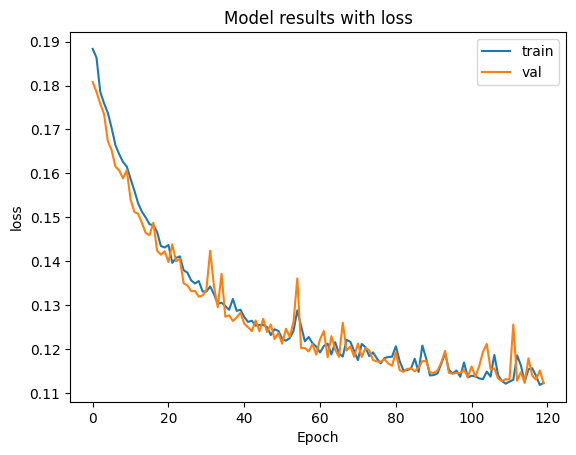

In [85]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

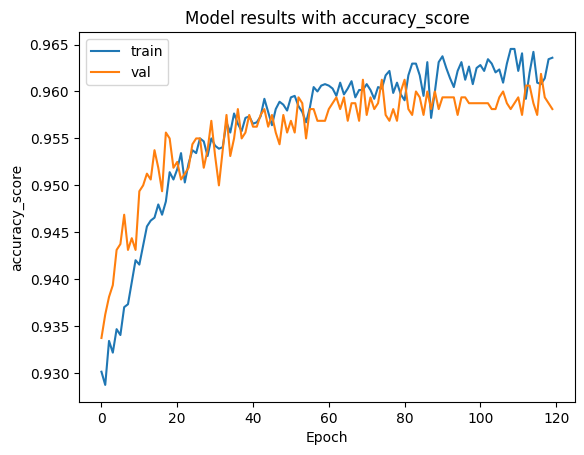

In [86]:
plot_metric(history, 'accuracy_score')

[]

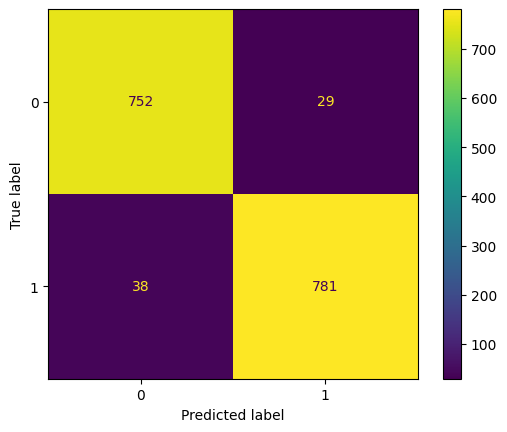

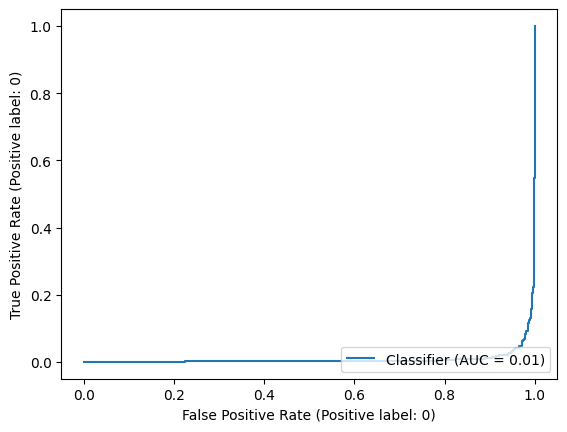

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np

device = torch.device("cpu")
model = model.to(device)
y_pred = model.predict(X_test, device=device)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=0)
plt.plot()


In [89]:
torch.save(model, "model.pt")

In [90]:
model = torch.load("/content/model.pt")
model

Model(
  (linear_1): Linear(in_features=7, out_features=20, bias=True)
  (linear_2): Linear(in_features=20, out_features=14, bias=True)
  (linear_3): Linear(in_features=14, out_features=10, bias=True)
  (linear_4): Linear(in_features=10, out_features=6, bias=True)
  (linear_5): Linear(in_features=6, out_features=1, bias=True)
)

In [91]:
device

device(type='cpu')

In [92]:
X_data = torch.FloatTensor(X_test.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)
print(y[1])

tensor([[0.4268, 0.4841, 0.3609, 0.4019, 0.5362, 0.6648, 0.4091]])
torch.Size([1, 7])
1


In [93]:
x = torch.FloatTensor(X_test.iloc[:1].values)
model.predict(X_data)

array([[0.02274893]], dtype=float32)